# Parallelised PMC

Using JAX we will add a parallel option for performing multiple simulations at once.

In [1]:
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow_probability
np = jax.numpy
tfp = tensorflow_probability.experimental.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

We first initialise the random state

In [2]:
rng = jax.random.PRNGKey(0)

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Example problem

### Simulator

We're going to infer the mean and variance used to generate 10 data points drawn from a normal distribution. The prior distribution is a uniform distribution where the mean is between -10 and 10 and a variance between 0 and 10.

In [3]:
input_shape = (10,)
data_points = np.prod(input_shape)
low = np.array([-10., 0.])
high = np.array([10., 10.])
prior = tfd.Blockwise([tfd.Uniform(low=low[i], high=high[i]) for i in range(low.shape[0])])

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


The simulator takes a random seed, the parameter values and a set of simulator parameters. The simulator only makes a single simulation. We then make a vectorised (or parallelised) simulator which passes a set of seeds and parameters to the simulator. The simulator needs to return some error (such as NaNs) in the shape of the data.

In [4]:
def simulator(key, θ, simulator_parameters=None):
    low, high, input_shape = simulator_parameters
    def simulate(args):
        key, θ = args
        return θ[0] + θ[1] * jax.random.normal(key, shape=input_shape)
    def error(args):
        return np.nan * np.ones(input_shape)
    return jax.lax.cond(
            np.logical_or(
                np.any(np.greater(θ, high)), 
                np.any(np.less(θ, low))),
        error,
        simulate,
        (key, θ))
    
def v_simulator(key, θ, simulator_parameters=None):
    if len(θ.shape) == 1:
        return simulator(key, θ, simulator_parameters=simulator_parameters)
    else:
        return jax.vmap(lambda key, θ : v_simulator(key, θ, simulator_parameters=simulator_parameters))(key, θ)

### Compressor

We also need to define a compression for a single simulation, in this case it is taking the mean and the standard deviation of the data.

In [5]:
def compressor(simulation):
    return np.stack([
     np.mean(simulation, axis=-1),
     np.std(simulation, axis=-1)], 
    axis=-1)

And then a function which gets compressed summaries of simulations in parallel.

In [6]:
def get_summary(key, θ, simulator_parameters=None):
    if len(θ.shape) == 1:
        return compressor(simulator(key, θ, simulator_parameters=simulator_parameters))
    else:
        return jax.vmap(lambda key, θ : get_summary(key, θ, simulator_parameters=simulator_parameters))(key, θ)

### Fisher information

We also need the Fisher information of the compressed summaries, which we know analytically for this problem

In [7]:
def F(θ, data_points):
    return -np.array([[-data_points / θ[1], 0.], [0., -data_points / (2. * θ[1]**2.)]])

# ABC

The ABC takes in the number of points, the proposal distribution, simulator and the summaries of any data (and their Fisher matrices). A random number generator also needs to be passed. The summaries are calculated in parallel and returned at which point the distance from the data is calculated.

In [8]:
def ABC(rng, n_points, proposal_distribution, simulator, data_summary, f, n_parallel_simulations=None, simulator_parameters=None):
    def get_distance(summaries, data_summary, f):
        if len(data_summary.shape) > 1:
            return jax.vmap(lambda data_summary, f : get_distance(summaries, data_summary, f))(data_summary, f)
        if len(summaries.shape) == 1:
            difference = summaries - data_summary
            distance = difference.dot(f).dot(difference)
            return jax.lax.cond(np.isnan(distance), lambda _ : np.inf, lambda distance : distance, distance)
        elif len(summaries.shape) == 2:
            return jax.vmap(lambda summaries : get_distance(summaries, data_summary, f), out_axes=-1)(summaries)
        else:
            return jax.vmap(lambda summaries : get_distance(summaries, data_summary, f), out_axes=-2)(summaries)
    shape = (n_points,)
    if n_parallel_simulations is not None:
        shape = shape + (n_parallel_simulations,)
    rng, key = jax.random.split(rng)
    proposed = proposal_distribution.sample(shape, seed=key)
    key = jax.random.split(rng, num=np.prod(proposed.shape[:-1]))
    summaries = simulator(key.reshape(proposed.shape[:-1] + (2,)), proposed, simulator_parameters=simulator_parameters)
    distances = get_distance(summaries, data_summary, f)
    return proposed, summaries, distances

### Example

We are going to generate three pieces of data, each with 10 doint points generated from a normal distribution, the first with a mean of 4 and variance of 7, the second with a mean of -3 and variance of 3 and the final one with a mean of 0 and a variance of 1. The Fisher matrix is then calculated assuming these values as the fiducial values.

In [9]:
θ = np.array([[4, 7], [-3, 3], [0, 1]])
rng, *key = jax.random.split(rng, num=np.prod(θ.shape[:-1])+1)
data_summary = get_summary(np.array(key).reshape(θ.shape[:-1] + (2,)), θ, simulator_parameters=(low, high, input_shape))
f = jax.vmap(lambda θ : F(θ, data_points))(θ)

Now as a comparison, we will run a normal ABC and one where the simulations are done in parallel, both starting with the same seed. Note that the timings for these should be identical because of the vectorisation.

In [10]:
n_points = 1000000
rng, key = jax.random.split(rng)
v_prop, v_summ, v_dist = ABC(key, n_points, prior, get_summary, data_summary, f, simulator_parameters=(low, high, input_shape))
p_prop, p_summ, p_dist = ABC(key, n_points // 1000, prior, get_summary, data_summary, f, n_parallel_simulations=1000, simulator_parameters=(low, high, input_shape))

We'll then accept samples within an ϵ ball of size 0.01 for both the normal and the parallelised ABC

In [11]:
v_accepted = v_dist < 1e-2
p_accepted = jax.vmap(lambda distances : distances < 1e-2)(p_dist)

And obviously the plots are equivalent

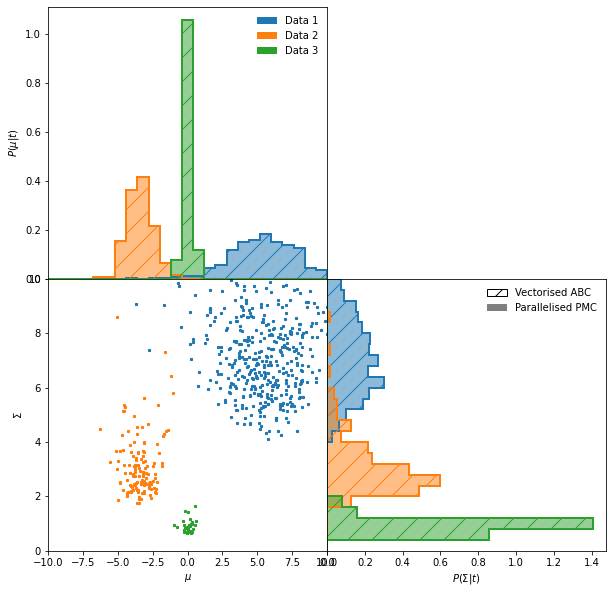

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)
ax[0, 0].set_xlim([prior.distributions[0].low, prior.distributions[0].high])
ax[0, 0].set_xticks([])
ax[0, 0].set_ylabel("$P(\mu|t)$")
ax[0, 1].axis("off")
ax[1, 0].set_xlim([prior.distributions[0].low, prior.distributions[0].high])
ax[1, 0].set_xlabel("$\mu$")
ax[1, 0].set_ylim([prior.distributions[1].low, prior.distributions[1].high])
ax[1, 0].set_ylabel("$\Sigma$")
ax[1, 1].set_xlabel("$P(\Sigma|t)$")
ax[1, 1].set_ylim([prior.distributions[1].low, prior.distributions[1].high])
ax[1, 1].set_yticks([])
for i in range(data_summary.shape[0]):
    ax[0, 0].hist(v_prop[v_accepted[i], 0], bins=25, range=[prior.distributions[0].low, prior.distributions[0].high], density=True, histtype="step", linewidth=2, hatch="/", edgecolor="C{}".format(i))
    ax[0, 0].hist(p_prop[p_accepted[i], 0], bins=25, range=[prior.distributions[0].low, prior.distributions[0].high], density=True, histtype="stepfilled", facecolor="C{}".format(i), alpha=0.5)
    ax[1, 0].scatter(v_prop[v_accepted[i], 0], v_prop[v_accepted[i], 1], marker=".", s=20, color="C{}".format(i))
    ax[1, 0].scatter(p_prop[p_accepted[i], 0], p_prop[p_accepted[i], 1], marker=",", s=5, color="C{}".format(i), alpha=0.5)
    ax[1, 1].hist(v_prop[v_accepted[i], 1], bins=25, range=[prior.distributions[1].low, prior.distributions[1].high], density=True, orientation="horizontal", histtype="step", linewidth=2, hatch="/", edgecolor="C{}".format(i))
    ax[1, 1].hist(p_prop[p_accepted[i], 1], bins=25, range=[prior.distributions[1].low, prior.distributions[1].high], density=True, orientation="horizontal", histtype="stepfilled", facecolor="C{}".format(i), alpha=0.5)    
ax[0, 0].legend(
    (mpl.patches.Patch(facecolor="C0"), 
     mpl.patches.Patch(facecolor="C1"),
     mpl.patches.Patch(facecolor="C2")),
    ("Data 1", "Data 2", "Data 3"),
    frameon=False)
ax[1, 1].legend(
    (mpl.patches.Patch(facecolor="None", edgecolor="black", hatch="/"),
     mpl.patches.Patch(facecolor="black", alpha=0.5)), 
    ("Vectorised ABC", "Parallelised PMC"),
    frameon=False);

# PMC

The PMC draws samples from a truncated multivariate normal, where the covariance is weighted depending on the probability of the samples.

In [13]:
def w_cov(proposed, weighting):
    weighted_samples = proposed * weighting[:, np.newaxis]
    return weighted_samples.T.dot(weighted_samples) / weighting.T.dot(weighting)

In [14]:
class tmvn():
    def __init__(self, loc, scale, low, high, max_counter=int(1e3)):
        self.loc = loc
        self.scale = scale
        self.low = low
        self.high = high
        if len(loc.shape) > 1:
            self.n_samples = loc.shape[0]
        else:
            self.n_samples = None
        self.n_params = low.shape[0]
        self.max_counter = max_counter
    
    def mvn(self, rng, loc):
        u = jax.random.normal(rng, shape=(self.n_params,))
        return loc + u.dot(self.scale)
    
    def w_cond(self, args):
        _, loc, counter = args
        return np.logical_and(
            np.logical_or(
                np.any(np.greater(loc, self.high)),
                np.any(np.less(loc, self.low))),
            np.less(counter, self.max_counter))
    
    def __sample(self, args):
        rng, loc, counter = args
        rng, key = jax.random.split(rng)
        return (rng, self.mvn(key, loc), counter+1)

    def _sample(self, rng, loc):
        rng, key = jax.random.split(rng)
        _, loc, counter = jax.lax.while_loop(
            self.w_cond, 
            self.__sample, 
            (rng, self.mvn(key, loc), 0))
        return jax.lax.cond(
            np.greater_equal(counter, self.max_counter),
            lambda _ : np.nan * np.ones((self.n_params,)),
            lambda _ : loc,
            None)
    
    def _sample_n(self, rng, loc, n=None):
        if n is None:
            return self._sample(rng, loc)
        else:
            key = jax.random.split(rng, num=n)
            return jax.vmap(self._sample)(key, 
                np.repeat(loc[np.newaxis], n, axis=0))
    
    def sample(self, shape=None, seed=None):
        if shape is None:
            if self.n_samples is None:
                return self._sample_n(seed, self.loc)
            else:
                key = jax.random.split(seed, num_self.n_samples)
                return jax.vmap(lambda key, loc : self._sample_n(key, loc))(key, self.loc)
        elif len(shape) == 1:
            if self.n_samples is None:
                return self._sample_n(seed, self.loc, n=shape[0])
            else:
                key = jax.random.split(seed, num_self.n_samples)
                return jax.vmap(lambda key, loc : self._sample_n(key, loc, n=shape[0]))(key, self.loc)
        else:
            key = jax.random.split(seed, num=shape[-1])
            return jax.vmap(lambda key: self.sample(shape=tuple(shape[:-1]), seed=key), out_axes=-2)(key)

And the PMC can then be run massively parallely and vectorised on as many data as wanted and with as many parallel simulations as can be run. The parallelisation will always pick the closest simulation out of the parallel set and work out the acceptance condition over the set - which therefore can increase the time efficiency of the PMC.

In [15]:
def PMC(rng, n_initial_points, n_points, prior, simulator, data_summary, f, percentile=75, acceptance_ratio=0.1, 
        max_iteration=10, max_acceptance=10, max_samples=int(1e3), n_parallel_simulations=None, simulator_parameters=None):
    low = np.array([dist.low for dist in prior.distributions])
    high = np.array([dist.high for dist in prior.distributions])
    def single_PMC(rng, samples, summaries, distances, weighting, data_summary, f):
        def single_iteration_condition(args):
            return np.logical_and(
                np.greater(args[-3], acceptance_ratio),
                np.less(args[-2], max_iteration))
        def single_iteration(args):
            def single_acceptance_condition(args):
                return np.logical_and(
                    np.less(args[-2], 1),
                    np.less(args[-1], max_acceptance))
            def single_acceptance(args):
                rng, loc, summ, dist, draws, accepted, acceptance_counter = args
                #rng, loc, summ, dist, draws, rejected, acceptance_counter = args
                rng, key = jax.random.split(rng)
                proposed, summaries, distances = ABC(
                    key, None, tmvn(loc, scale, low, high, max_counter=max_samples),
                    simulator, data_summary, f, n_parallel_simulations=n_parallel_simulations,
                    simulator_parameters=simulator_parameters)
                if n_parallel_simulations is not None:
                    min_distance_index = np.argmin(distances)
                    min_distance = distances[min_distance_index]
                    closer = np.less(min_distance, ϵ)
                    loc = jax.lax.cond(closer, lambda _ : proposed[min_distance_index], lambda _ : loc, None)
                    summ = jax.lax.cond(closer, lambda _ : summaries[min_distance_index], lambda _ : summ, None)
                    dist = jax.lax.cond(closer, lambda _ : distances[min_distance_index], lambda _ : dist, None)
                    iteration_draws = n_parallel_simulations - np.isinf(distances).sum()
                    draws += iteration_draws 
                    accepted = closer.sum()
                    #rejected = iteration_draws - closer.sum()
                else:
                    closer = np.less(distances, dist)
                    loc = jax.lax.cond(closer, lambda _ : proposed, lambda _ : loc, None)
                    summ = jax.lax.cond(closer, lambda _ : summaries, lambda _ : summ, None)
                    dist = jax.lax.cond(closer, lambda _ : distances, lambda _ : dist, None)
                    iteration_draws = 1 - np.isinf(distances).sum()
                    draws += iteration_draws
                    accepted = closer.sum()
                    #rejected = iteration_draws - closer.sum()
                return (rng, loc, summ, dist, draws, accepted, acceptance_counter+1)
                #return (rng, loc, summ, dist, draws, rejected, acceptance_counter+1)

            rng, samples, summaries, distances, weighting, data_summary, f, acceptance_reached, iteration_counter, total_draws = args
            ϵ = distances[ϵ_ind]
            loc = samples[ϵ_ind:]
            cov = w_cov(samples, weighting)
            inv_cov = np.linalg.inv(cov)
            scale = np.linalg.cholesky(cov)
            rng, *key = jax.random.split(rng, num=loc.shape[0]+1)
            draws = np.zeros(loc.shape[0], dtype=np.int32)
            accepted = np.zeros(loc.shape[0], dtype=np.int32)
            #rejected = np.zeros(loc.shape[0], dtype=np.int32)
            acceptance_counter = np.zeros(loc.shape[0], dtype=np.int32)

            results = jax.vmap(
                lambda key, loc, summaries, distances, draws, accepted, acceptance_counter : jax.lax.while_loop(
                #lambda key, loc, summaries, distances, draws, rejected, acceptance_counter : jax.lax.while_loop(
                    single_acceptance_condition, single_acceptance, (key, loc, summaries, distances, draws, accepted, acceptance_counter)))(
                    #single_acceptance_condition, single_acceptance, (key, loc, summaries, distances, draws, rejected, acceptance_counter)))(
                np.array(key), loc, summaries[ϵ_ind:], distances[ϵ_ind:], draws, accepted, acceptance_counter)
                #np.array(key), loc, summaries[ϵ_ind:], distances[ϵ_ind:], draws, rejected, acceptance_counter)

            weighting = jax.vmap(
                lambda proposed : (
                    prior.prob(proposed) 
                    / (np.sum(weighting * tfd.MultivariateNormalTriL(
                        loc=samples,
                        scale_tril=np.repeat(
                            scale[np.newaxis], 
                            samples.shape[0], 
                            axis=0)).prob(proposed)))))(
                    np.vstack([samples[:ϵ_ind], results[1]]))
            samples = jax.ops.index_update(samples, jax.ops.index[ϵ_ind:, :], results[1])
            summaries = jax.ops.index_update(summaries, jax.ops.index[ϵ_ind:, :], results[2])
            distances = jax.ops.index_update(distances, jax.ops.index[ϵ_ind:], results[3])
            acceptance_reached = results[-2].sum() / results[-3].sum()
            return (rng, samples, summaries, distances, weighting, data_summary, f, acceptance_reached, iteration_counter+1, total_draws+results[-3].sum())
        
        acceptance_reached = np.inf
        iteration_counter = 0
        total_draws = 0
        results = jax.lax.while_loop(
            single_iteration_condition, 
            single_iteration, 
            (rng, samples, summaries, distances, weighting, data_summary, f, acceptance_reached, iteration_counter, total_draws))
        return results[1], results[2], results[3], results[4], results[7], results[8], results[9]

    rng, key = jax.random.split(rng)
    proposed, summaries, distances = ABC(
        key, n_initial_points, prior, simulator, data_summary, f, 
        n_parallel_simulations=n_parallel_simulations, simulator_parameters=simulator_parameters)
        
    if n_parallel_simulations is not None:
        proposed = proposed.reshape((n_initial_points * n_parallel_simulations, -1))
        summaries = summaries.reshape((n_initial_points * n_parallel_simulations, -1))
        if len(data_summary.shape) > 1:
            distances = distances.reshape((data_summary.shape[0], -1))
        else:
            distances = distances.reshape((-1,))
            
    if len(data_summary.shape) == 1:
        sample_indices = np.argsort(distances)[:n_points]
        samples = proposed[sample_indices]
        summaries = summaries[sample_indices]
        distances = distances[sample_indices]
    else:
        sample_indices = np.argsort(distances, axis=1)[:, :n_points]
        samples = jax.vmap(lambda x: proposed[x])(sample_indices)
        summaries = jax.vmap(lambda x: summaries[x])(sample_indices)
        distances = np.take_along_axis(distances, sample_indices, axis=1)    

    weighting = prior.prob(samples)

    if percentile is None:
        ϵ_ind = -1
        to_accept = 1
    else:
        ϵ_ind = int(percentile / 100 * n_points)
        to_accept = n_points - ϵ_ind

    if len(data_summary.shape) == 1:
        return single_PMC(rng, samples, summaries, distances, weighting, data_summary, f)
    else:
        key = jax.random.split(rng, num=data_summary.shape[0])
        return jax.vmap(single_PMC)(key, samples, summaries, distances, weighting, data_summary, f)

To get 250 points in each posterior, starting with 1000 ABC simulations, and performing 100 parallel simulations (with a maxmimum of 100 iterations). Because samples can be from outside the prior then simulations can be rejected - a maxmimum of 1000 simulations can be drawn from outside the prior before returning a NaN and a maxmimum of 1000 at getting a proposed sample accepted in any iteration are attepted before redrawing the sample from the prior.

In [16]:
rng, key = jax.random.split(rng)
ppmc_prop, ppmc_summ, ppmc_dist, ppmc_w, ppmc_crit, ppmc_it, ppmc_draws = PMC(
    rng=key, n_initial_points=1000, n_points=250, prior=prior, simulator=get_summary, data_summary=data_summary, f=f, percentile=75, acceptance_ratio=0.5, 
    max_iteration=int(1e2), max_acceptance=int(1e3), max_samples=int(1e3), n_parallel_simulations=100, simulator_parameters=(low, high, input_shape))

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


Comparing this to the ABC gives

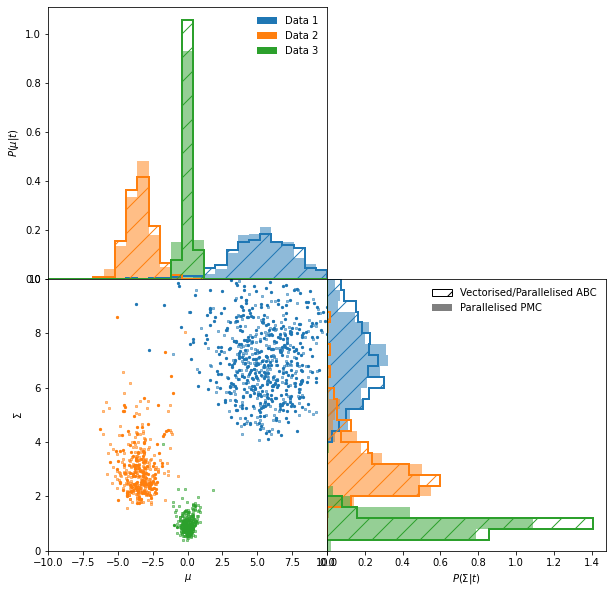

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)
ax[0, 0].set_xlim([prior.distributions[0].low, prior.distributions[0].high])
ax[0, 0].set_xticks([])
ax[0, 0].set_ylabel("$P(\mu|t)$")
ax[0, 1].axis("off")
ax[1, 0].set_xlim([prior.distributions[0].low, prior.distributions[0].high])
ax[1, 0].set_xlabel("$\mu$")
ax[1, 0].set_ylim([prior.distributions[1].low, prior.distributions[1].high])
ax[1, 0].set_ylabel("$\Sigma$")
ax[1, 1].set_xlabel("$P(\Sigma|t)$")
ax[1, 1].set_ylim([prior.distributions[1].low, prior.distributions[1].high])
ax[1, 1].set_yticks([])
for i in range(data_summary.shape[0]):
    ax[0, 0].hist(v_prop[v_accepted[i], 0], bins=25, range=[prior.distributions[0].low, prior.distributions[0].high], density=True, histtype='step', linewidth=2, hatch='/', edgecolor='C{}'.format(i))
    ax[0, 0].hist(ppmc_prop[i, :, 0], bins=25, range=[prior.distributions[0].low, prior.distributions[0].high], density=True, histtype='stepfilled', facecolor='C{}'.format(i), alpha=0.5)
    ax[1, 0].scatter(v_prop[v_accepted[i], 0], v_prop[v_accepted[i], 1], marker=".", s=20, color="C{}".format(i))
    ax[1, 0].scatter(ppmc_prop[i, :, 0], ppmc_prop[i, :, 1], marker=",", s=5, color="C{}".format(i), alpha=0.5)
    ax[1, 1].hist(v_prop[v_accepted[i], 1], bins=25, range=[prior.distributions[1].low, prior.distributions[1].high], density=True, orientation="horizontal", histtype='step', linewidth=2, hatch='/', edgecolor='C{}'.format(i))
    ax[1, 1].hist(ppmc_prop[i, :, 1], bins=25, range=[prior.distributions[1].low, prior.distributions[1].high], density=True, orientation="horizontal", histtype='stepfilled', facecolor='C{}'.format(i), alpha=0.5)    
ax[0, 0].legend(
    (mpl.patches.Patch(facecolor="C0"), 
     mpl.patches.Patch(facecolor="C1"),
     mpl.patches.Patch(facecolor="C2")),
    ("Data 1", "Data 2", "Data 3"),
    frameon=False)
ax[1, 1].legend(
    (mpl.patches.Patch(facecolor="None", edgecolor="black", hatch="/"),
     mpl.patches.Patch(facecolor="black", alpha=0.5)), 
    ("Vectorised/Parallelised ABC", "Parallelised PMC"),
    frameon=False);

The number of draws (minus those done for the ABC), the criteria reached and number of iterations in the PMC are available too

In [18]:
print("Total number of draws = {}".format(ppmc_draws))
print("Acceptance in last iteration = {}".format(ppmc_crit))
print("Number of iterations = {}".format(ppmc_it))

Total number of draws = [19057 16255  6359]
Acceptance in last iteration = [0.00330587 0.00387573 0.00990722]
Number of iterations = [1 1 1]


We can compare this to a non-parallelised PMC

In [22]:
rng, key = jax.random.split(rng)
pmc_prop, pmc_summ, pmc_dist, pmc_w, pmc_crit, pmc_it, pmc_draws = PMC(
    rng=key, n_initial_points=1000, n_points=250, prior=prior, simulator=get_summary, data_summary=data_summary, f=f, percentile=75, acceptance_ratio=0.5 / 100, 
    max_iteration=int(1e2), max_acceptance=int(1e3), max_samples=int(1e3), n_parallel_simulations=None, simulator_parameters=(low, high, input_shape))

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


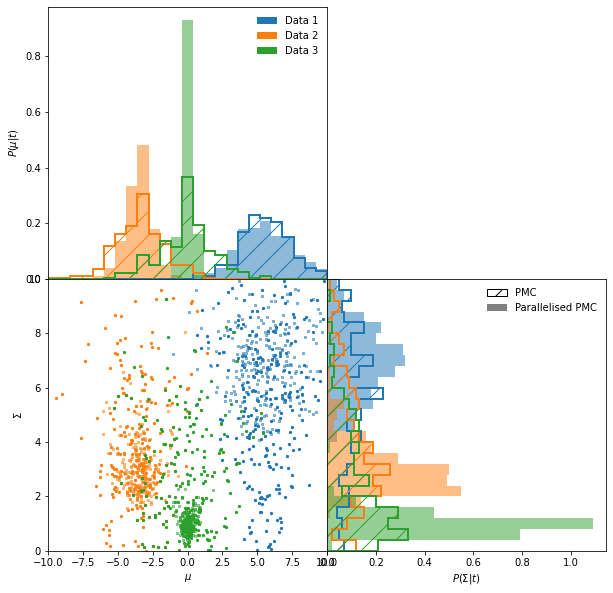

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)
ax[0, 0].set_xlim([prior.distributions[0].low, prior.distributions[0].high])
ax[0, 0].set_xticks([])
ax[0, 0].set_ylabel("$P(\mu|t)$")
ax[0, 1].axis("off")
ax[1, 0].set_xlim([prior.distributions[0].low, prior.distributions[0].high])
ax[1, 0].set_xlabel("$\mu$")
ax[1, 0].set_ylim([prior.distributions[1].low, prior.distributions[1].high])
ax[1, 0].set_ylabel("$\Sigma$")
ax[1, 1].set_xlabel("$P(\Sigma|t)$")
ax[1, 1].set_ylim([prior.distributions[1].low, prior.distributions[1].high])
ax[1, 1].set_yticks([])
for i in range(data_summary.shape[0]):
    ax[0, 0].hist(pmc_prop[i, :, 0], bins=25, range=[prior.distributions[0].low, prior.distributions[0].high], density=True, histtype='step', linewidth=2, hatch='/', edgecolor='C{}'.format(i))
    ax[0, 0].hist(ppmc_prop[i, :, 0], bins=25, range=[prior.distributions[0].low, prior.distributions[0].high], density=True, histtype='stepfilled', facecolor='C{}'.format(i), alpha=0.5)
    ax[1, 0].scatter(pmc_prop[i, :, 0], pmc_prop[i, :, 1], marker=".", s=20, color="C{}".format(i))
    ax[1, 0].scatter(ppmc_prop[i, :, 0], ppmc_prop[i, :, 1], marker=",", s=5, color="C{}".format(i), alpha=0.5)
    ax[1, 1].hist(pmc_prop[i, :, 1], bins=25, range=[prior.distributions[1].low, prior.distributions[1].high], density=True, orientation="horizontal", histtype='step', linewidth=2, hatch='/', edgecolor='C{}'.format(i))
    ax[1, 1].hist(ppmc_prop[i, :, 1], bins=25, range=[prior.distributions[1].low, prior.distributions[1].high], density=True, orientation="horizontal", histtype='stepfilled', facecolor='C{}'.format(i), alpha=0.5)    
ax[0, 0].legend(
    (mpl.patches.Patch(facecolor="C0"), 
     mpl.patches.Patch(facecolor="C1"),
     mpl.patches.Patch(facecolor="C2")),
    ("Data 1", "Data 2", "Data 3"),
    frameon=False)
ax[1, 1].legend(
    (mpl.patches.Patch(facecolor="None", edgecolor="black", hatch="/"),
     mpl.patches.Patch(facecolor="black", alpha=0.5)), 
    ("PMC", "Parallelised PMC"),
    frameon=False);

In [24]:
print("Total number of draws = {}".format(pmc_draws))
print("Acceptance in last iteration = {}".format(pmc_crit))
print("Number of iterations = {}".format(pmc_it))

Total number of draws = [25984 32667 24822]
Acceptance in last iteration = [0.00364046 0.0036813  0.00419783]
Number of iterations = [5 6 5]


We can expect many fewer iterations of the parallelised PMC because the closest of the parallel simulations is chosen.

# TODO

- Both the parallel and the non-parallel PMC are using the acceptance ratio as a stopping condition then equivalent ratios are different for different number of parellel simulations.
- The non-parallel PMC seems to be quite diffuse along the variance direction, I'm not sure if this is a bug?